# Results R1b: What sentiments and topics are present in the diary chunks?

## Multilevel model with random intercepts

### Resources

In [9]:
# Get Packages & Libraries
library(tidyverse)
library(brms)
library(ggridges)
#library(tidybayes)
#library(bayesplot)
library(rethinking)

In [10]:
# Functions
factorize <- function(df){ # Create a function
  for(i in which(sapply(df, class) == "character")) # that looks for variables with the character class 
      df[[i]] = as.factor(df[[i]]) # and converts them to factor (i.e., categorical) class
  return(df)
}

In [11]:
# Get Data
df2  <- read.csv("20240702_PhD_FinalData-DiaryChk.csv")
df2[df2 == ''] <- NA #replace blank cells with NA
df2 <- factorize(df2)
glimpse(df2)

Rows: 1,023
Columns: 41
$ docid            <fct> D0002, D0002, D0002, D0002, D0002, D0002, D0002, D000…
$ docyear          <int> 1883, 1883, 1883, 1883, 1883, 1883, 1883, 1883, 1883,…
$ docmonth         <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ authorName       <fct> Anne F. Richards, Anne F. Richards, Anne F. Richards,…
$ docauthorid      <fct> D0002, D0002, D0002, D0002, D0002, D0002, D0002, D000…
$ authorLocation   <fct> Australia, Australia, Australia, Australia, Australia…
$ authorGender     <fct> F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F,…
$ nationalOrigin   <fct> English, English, English, English, English, English,…
$ irish            <fct> False, False, False, False, False, False, False, Fals…
$ otherUK          <fct> True, True, True, True, True, True, True, True, True,…
$ relMin           <fct> False, False, False, False, False, False, False, Fals…
$ catholic         <fct> False, False, False, False, False, False, False, Fals…
$ otherChristian

### Transformations

In [12]:
# Get counts for topic number
table(as.factor(df2$topicNumber))

# Create new variable with topic labels that match pyLDAvis label numbers
df2$topicLabel <- as.character(df2$topicNumber)
df2$topicLabel[df2$topicLabel=="0"]  <- "01 Housework"
df2$topicLabel[df2$topicLabel=="1"]  <- "02 Places"
df2$topicLabel[df2$topicLabel=="2"]  <- "03 Business"
df2$topicLabel[df2$topicLabel=="3"]  <- "04 Girl Privilege"
df2$topicLabel[df2$topicLabel=="4"]  <- "05 Working Boy"
df2$topicLabel[df2$topicLabel=="5"]  <- "06 Weather"
df2$topicLabel[df2$topicLabel=="6"]  <- "07 People"
df2$topicLabel[df2$topicLabel=="7"]  <- "08 Politics"
df2$topicLabel[df2$topicLabel=="8"]  <- "09 Outback"
df2$topicLabel[df2$topicLabel=="9"]  <- "10 Home"
df2$topicLabel <- as.factor(df2$topicLabel)

# Check
df2 %>% select(topicNumber, topicLabel) %>% unique() %>% arrange(topicLabel)
table(df2$topicLabel)
sum(is.na(df2$topicLabel))


  0   1   2   3   4   5   6   7   8   9 
135 111 100 144 107  71  89 109  93  64 

topicNumber,topicLabel
<int>,<fct>
0,01 Housework
1,02 Places
2,03 Business
3,04 Girl Privilege
4,05 Working Boy
5,06 Weather
6,07 People
7,08 Politics
8,09 Outback



     01 Housework         02 Places       03 Business 04 Girl Privilege 
              135               111               100               144 
   05 Working Boy        06 Weather         07 People       08 Politics 
              107                71                89               109 
       09 Outback           10 Home 
               93                64 

[1] 0

In [13]:
#Socials Variable Prep
df2$mentsRate <- df2$mentsTot/df2$totalTokens
df2$fppAllRate <- df2$fppAll_Ct/df2$totalTokens
df2$fppSubRate <- df2$fppSub_Ct/df2$totalTokens

### Check that rethinking and brms code giving similar results

In [14]:
f1s <- readRDS("20240826_PhD_DiaChkSen_01.rds")
precis(f1s, prob=.95)

,mean,sd,2.5%,97.5%
,<dbl>,<dbl>,<dbl>,<dbl>
mu,-0.07048127,0.011240748,-0.09251273,-0.04844981
sigma,0.36181916,0.007998839,0.34614172,0.37749660


In [15]:
# Used this to verify that brm giving the same result as quap for single level model. All good.
#f1s <- brm(data=df2,family=gaussian,scoreCom ~ 1,prior=c(prior("normal(0,.5)",class=Intercept),prior("exponential(1)",class=sigma)),iter=2000,warmup = 1000,chains=4,cores=4, seed = 4,file = "20240816_PhD_DiaChkSenBRMS_01")
f2s <- readRDS("20240816_PhD_DiaChkSenBRMS_01.rds")
posterior_summary(f2s)[1:2,]

,Estimate,Est.Error,Q2.5,Q97.5
b_Intercept,-0.07150741,0.011436556,-0.09398006,-0.04922811
sigma,0.36220174,0.008122071,0.34636282,0.37844459


### Sentiment

#### Actual Data

docid,min,mean,max,sd
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
D0002,-0.9916000,-0.17930252,0.9886000,0.5117184
D0003,-0.1437333,0.08773990,0.6323500,0.1130969
D0007,-0.3999000,-0.02004793,0.3183571,0.1094423
D0009,-0.2258500,0.03078770,0.4502333,0.1086464


Picking joint bandwidth of 0.0562



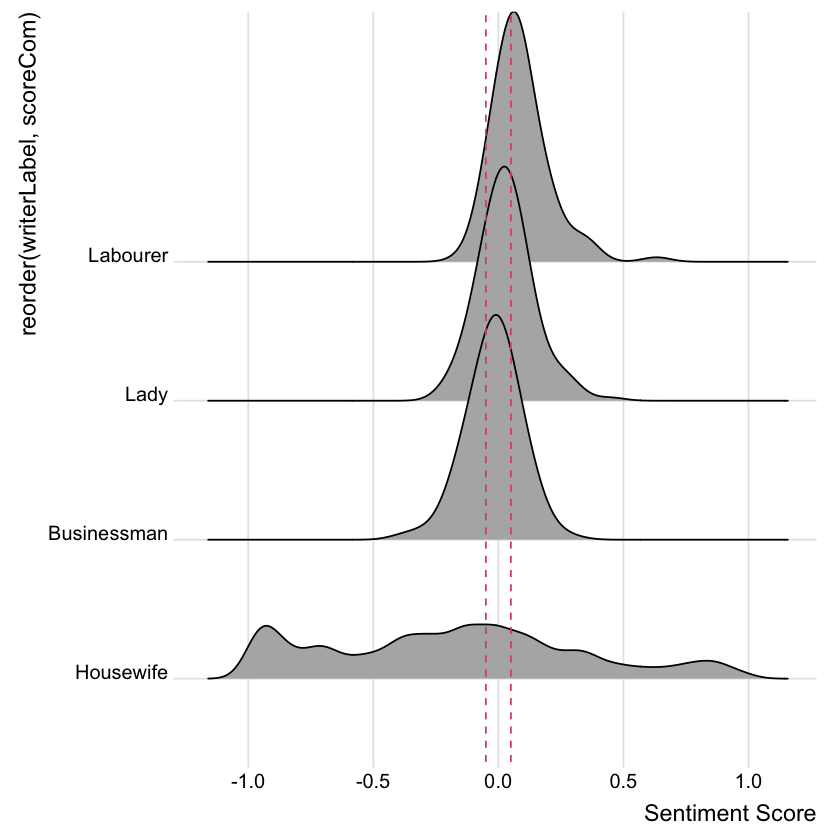

In [66]:
df2 %>% 
select(docid, scoreCom) %>% 
group_by(docid) %>% 
summarize(min = min(scoreCom),
          mean = mean(scoreCom), 
          max = max(scoreCom), 
          sd = sd(scoreCom))

actualData <- df2 %>% 
select(docid, scoreCom) 

actualData$writerLabel[actualData$docid=="D0002"] <- "Housewife"
actualData$writerLabel[actualData$docid=="D0003"] <- "Labourer"
actualData$writerLabel[actualData$docid=="D0007"] <- "Businessman"
actualData$writerLabel[actualData$docid=="D0009"] <- "Lady"

ggplot(actualData, aes(x = scoreCom, y = reorder(writerLabel, scoreCom))) +
  geom_density_ridges() +
  geom_vline(xintercept = c(-.05, .05),
             linetype = 2,
             color = 2)+
  theme_ridges() + 
  theme(legend.position = "none") + 
xlab("Sentiment Score") 

The model needs to accommodate the high variance of the housewife's distribution while also regularizing it with the other categories. Is no pooling or pooling best?

#### Selected Model Specification & Results

<p>Partial Pooling Model</p>

$$sentimentDiary_{ik} \sim Normal(\mu_{ik}, \sigma)$$
$$\mu_{ik} = \alpha_k$$
$$\alpha_k \sim Normal(\gamma, \phi)* $$ 
$$\gamma \sim Normal(0,0.1)* $$ 
$$\phi \sim Uniform(0,0.2)* $$
$$\sigma \sim Uniform(0,0.4)**$$ 

<ul>
    <li>* Typical writer (fixed)</li>
    <li>** Variability for each writer (random).</li>
</ul>

<p>For general notation, see https://soci620.netlify.app/slides/soci620_19_randomIntercepts.pdf and https://soci620.netlify.app/slides/soci620_18_nestedDataPartialPooling.pdf, noting that $\phi$ and $\eta$ are used in the different examples to represent sd (variability between all classrooms). I used $\phi$ here.
<p>For Exponential priors, see McElreath (2020, pp. 119, 407-408) and Kurtz (2023, sections 4.5.2 and 13.1.0.2).</p>

In [1]:
f1mupp <- readRDS("20240829_PhD_DiaChkSen_mupp.rds")
print(f1mupp)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ 1 + (1 | docauthorid) 
   Data: df2 (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 4) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.13      0.04     0.06     0.19 1.00     1276     1209

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    -0.02      0.05    -0.12     0.09 1.00     1093     1570

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.35      0.01     0.33     0.36 1.00     2065     1762

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at converge

In [2]:
#f1mupp <- brm(data=df2,
#            family = 'gaussian',
#            formula= scoreCom ~ 1 + (1 | docauthorid),
#            prior=c(set_prior("normal(0,0.1)",class="Intercept"),
#                    set_prior("uniform(0,0.2)",class="sd", ub=0.2),
#                    set_prior("uniform(0,0.4)",class="sigma", ub=0.4)),
#            iter=2000, warmup = 1000, chains=4, cores=4, seed = 4,
#            file = "20240829_PhD_DiaChkSen_mupp.rds",
#            control=list(adapt_delta=.99))
#print(f1mupp)

Picking joint bandwidth of 0.0597



    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.39096 -0.26933 -0.02550 -0.02264  0.22037  1.44635 

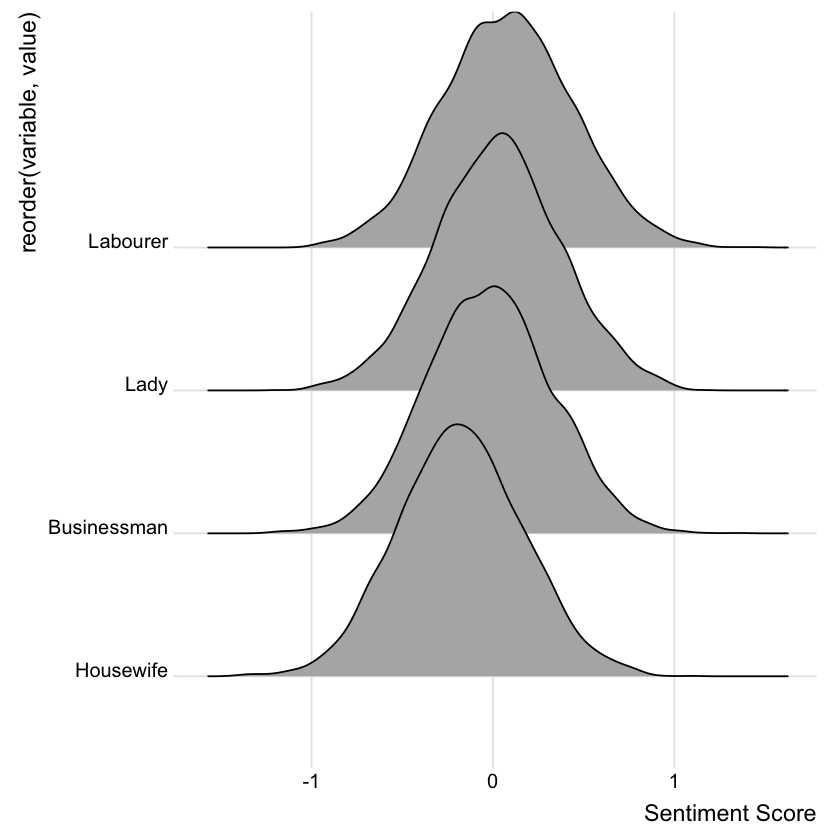

In [210]:
nd <- distinct(df2, docauthorid)

f <-
  predict(f1mupp,
         newdata = nd,
         summary = F)  %>% 
data.frame()

colnames(f) <- c("Housewife", "Labourer", "Businessman", "Lady")

f <- f %>%                                   
  gather(variable, value) 

ggplot(f, aes(x = value, y = reorder(variable, value))) +
  geom_density_ridges() +
theme_ridges() + 
  theme(legend.position = "none") + 
xlab("Sentiment Score") 

summary(f$value)

In [211]:
# Random Effects
post_mdn <- 
  coef(f1mupp, robust = T)$docauthorid[, , ] %>% 
  data.frame()

head(post_mdn)

,Estimate,Est.Error,Q2.5,Q97.5
,<dbl>,<dbl>,<dbl>,<dbl>
D0002,-0.17536743,0.01559321,-0.20844056,-0.14381199
D0003,0.07880060,0.03329799,0.01396528,0.14528560
D0007,-0.01990695,0.01847367,-0.05839113,0.01744742
D0009,0.02767780,0.02722107,-0.02561904,0.08119142


Picking joint bandwidth of 0.00959



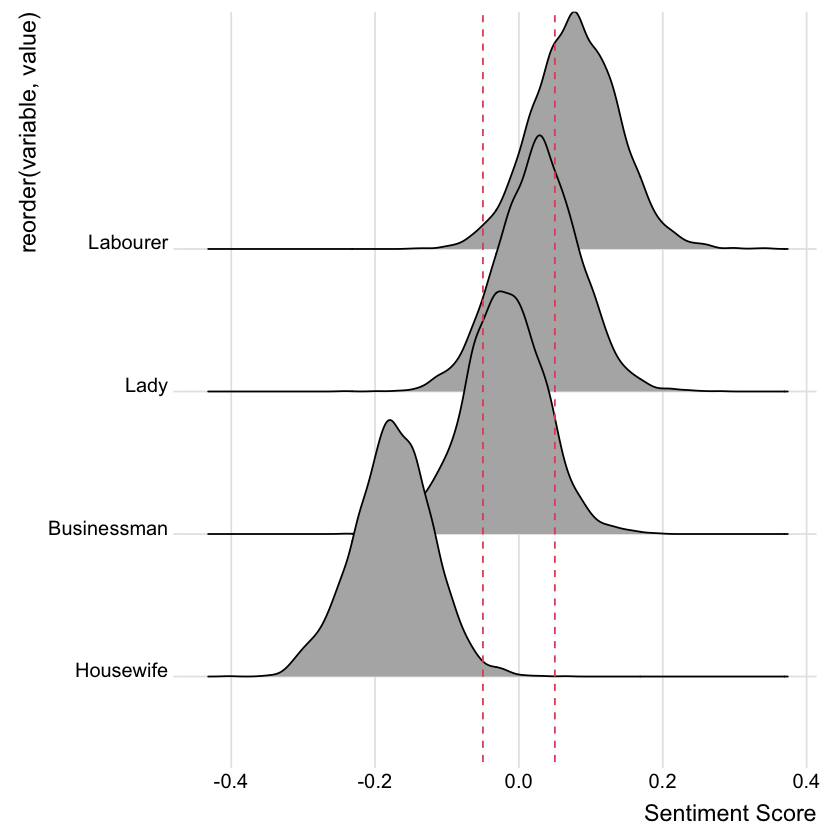

In [212]:
#Visualized Random Effects (Means)

nd <- distinct(df2, docauthorid)

f <- data.frame(ranef(f1mupp,
         newdata = nd,
         re_formula = NA,
         probs = c(.1, .90), 
         summary = F))

colnames(f) <- c("Housewife", "Labourer", "Businessman", "Lady")

fe <- fixef(f1mupp, probs = .90)

f$Housewife <- fe[1,1] + f$Housewife
f$Labourer <- fe[1,1] + f$Labourer
f$Businessman <- fe[1,1] + f$Businessman
f$Lady <- fe[1,1] + f$Lady

f <- f %>%                                   
  gather(variable, value) 

ggplot(f, aes(x = value, y = reorder(variable, value))) +
  geom_density_ridges() +
  geom_vline(xintercept = c(-.05, .05),
             linetype = 2,
             color = 2)+
  theme_ridges() + 
  theme(legend.position = "none") + 
xlab("Sentiment Score")

#ggsave("20240822_PhD_DiaSenWri.png")

<p>No Pooling Model</p>

$$sentimentDiary_{ik} \sim Normal(\mu_{ik}, \sigma)$$
$$\mu_{ik} = \alpha_k*$$ 
$$\alpha_k \sim Normal(0,0.1)$$ 
$$\sigma \sim Uniform(0,0.4)$$ 

<ul>
    <li>* Each writer has its own independent intercept</li>
    <li>See specification b5.9 in Kurz (2023, Version 0.4.0).</li>
    <li>See https://soci620.netlify.app/slides/soci620_18_nestedDataPartialPooling.pdf
    <li>McElreath(2020, Section 13.2.4. and p. 414</li>
</ul>

In [3]:
f1munp <- readRDS("20240829_PhD_DiaChkSen_munp.rds")
print(f1munp)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: scoreCom ~ 0 + docauthorid 
   Data: df2 (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Regression Coefficients:
                 Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
docauthoridD0002    -0.17      0.02    -0.21    -0.14 1.00     4009     2972
docauthoridD0003     0.08      0.03     0.01     0.14 1.00     3954     2581
docauthoridD0007    -0.02      0.02    -0.06     0.02 1.00     4080     2656
docauthoridD0009     0.03      0.03    -0.02     0.08 1.00     4084     2426

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.35      0.01     0.33     0.36 1.00     4037     2312

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on

In [4]:
# No pooling
#f1munp <- brm(data=df2,
#            family = 'gaussian',
#            formula= scoreCom ~ 0 + docauthorid, # **
#            prior=c(set_prior("normal(0,.1)",class="b"),
#                    set_prior("uniform(0,0.4)",class="sigma", ub = 0.4)),
#            iter=2000, warmup = 1000, chains=4, cores=4, seed = 4,
#            file = "20240829_PhD_DiaChkSen_munp",
#            control=list(adapt_delta=.99))
#print(f1munp)

# See Kurz (2023, version 0.4.0, Section 13.2.4 and Model b5.8) for specification
## This can also be achieved using -1 + notation described in https://soci620.netlify.app/labs/lab_17.Rmd
### See pg 14

Picking joint bandwidth of 0.0596



    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.50463 -0.26878 -0.02412 -0.02310  0.22452  1.65615 

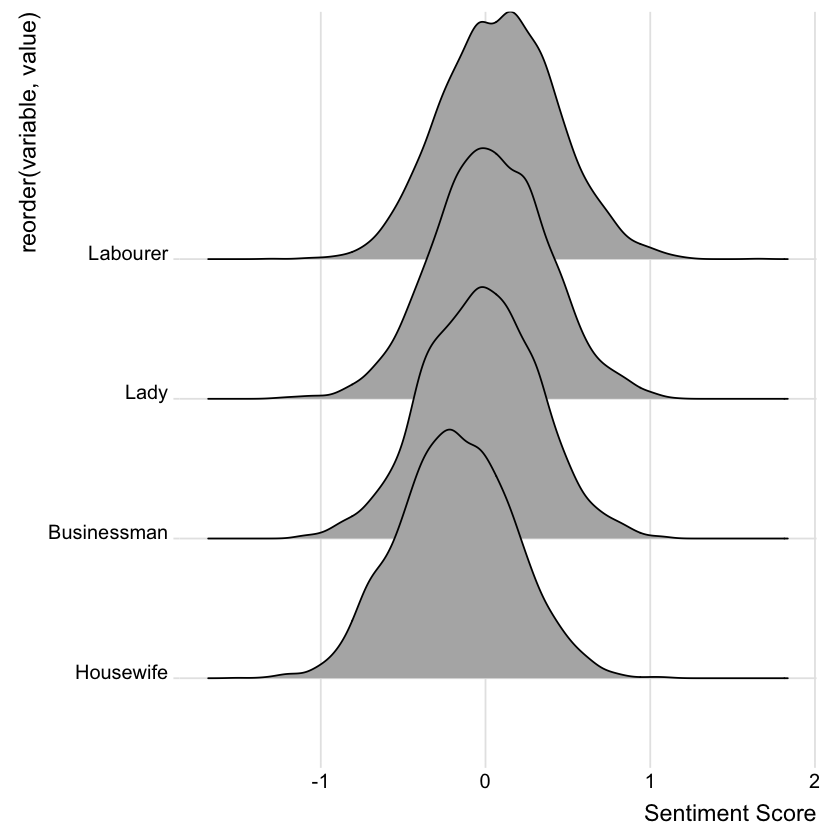

In [199]:
nd <- distinct(df2, docauthorid)

f <-
  predict(f1munp,
         newdata = nd,
         summary = F)  %>% 
data.frame()

colnames(f) <- c("Housewife", "Labourer", "Businessman", "Lady")

f <- f %>%                                   
  gather(variable, value) 

ggplot(f, aes(x = value, y = reorder(variable, value))) +
  geom_density_ridges() +
theme_ridges() + 
  theme(legend.position = "none") + 
xlab("Sentiment Score") 

summary(f$value)

Picking joint bandwidth of 0.00405



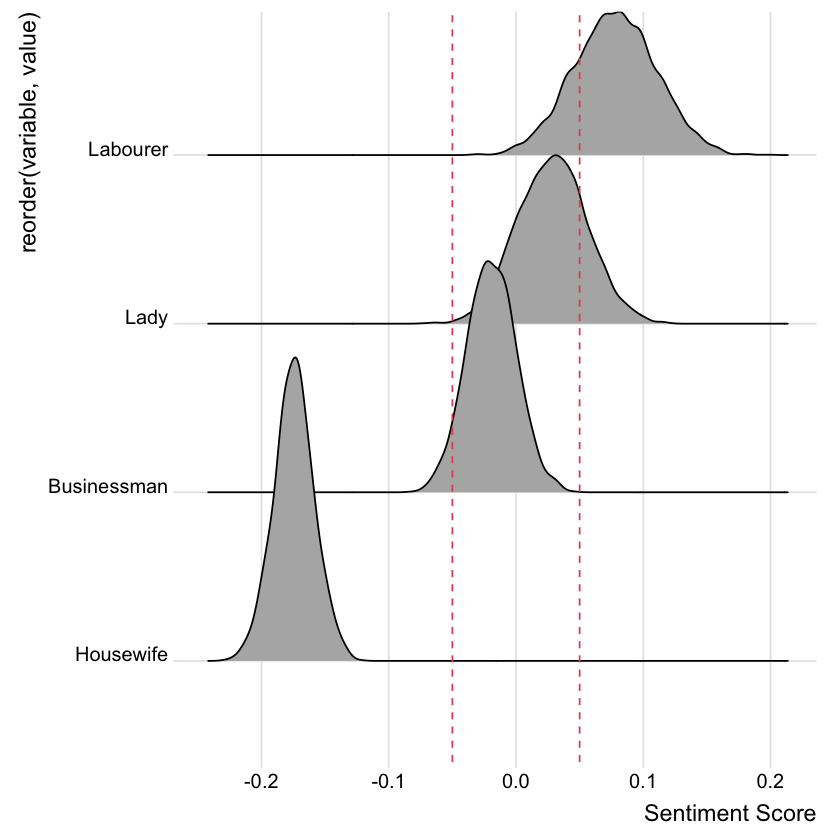

In [206]:
# Means

nd <- distinct(df2, docauthorid)

f <- data.frame(fixef(f1munp,
         newdata = nd,
         probs = c(.1, .90), 
         summary = F))

colnames(f) <- c("Housewife", "Labourer", "Businessman", "Lady")

f <- f %>%                                   
  gather(variable, value)

ggplot(f, aes(x = value, y = reorder(variable, value))) +
  geom_density_ridges() +
  theme_ridges() + 
  geom_vline(xintercept = c(-.05, .05),
             linetype = 2,
             color = 2)+
  theme(legend.position = "none") + 
xlab("Sentiment Score") 

#### Model Comparison

In [16]:
# Compare Models
f2s_i <- add_criterion(f2s, "waic")
f1mupp_i <- add_criterion(f1mupp, "waic")
f1munp_i <- add_criterion(f1munp, "waic") 

w <- loo_compare(f2s_i, f1mupp_i, f1munp_i, criterion = "waic")

print(w, simplify = F)

         elpd_diff se_diff elpd_waic se_elpd_waic p_waic se_p_waic waic  
f1mupp_i    0.0       0.0  -375.5      31.0          4.2    0.3     751.1
f1munp_i    0.0       0.1  -375.5      31.0          4.1    0.3     751.1
f2s_i     -38.4       9.5  -413.9      28.8          2.7    0.2     827.9
         se_waic
f1mupp_i   62.1 
f1munp_i   61.9 
f2s_i      57.7 


### Topics

#### Actual Data

In [214]:
df2 %>%count(topicLabel) %>%mutate(percent = n / sum(n) * 100)%>% arrange(desc(percent))

topicLabel,n,percent
<fct>,<int>,<dbl>
04 Girl Privilege,144,14.076246
01 Housework,135,13.196481
02 Places,111,10.850440
08 Politics,109,10.654936
05 Working Boy,107,10.459433
03 Business,100,9.775171
09 Outback,93,9.090909
07 People,89,8.699902
06 Weather,71,6.940371


In [217]:
table(df2$topicLabel, df2$docauthorid)

                   
                    D0002 D0003 D0007 D0009
  01 Housework        131     0     0     4
  02 Places             0     0   111     0
  03 Business           0     0   100     0
  04 Girl Privilege     5     0     0   139
  05 Working Boy        2   100     0     5
  06 Weather           69     0     2     0
  07 People            88     0     1     0
  08 Politics           0     0   109     0
  09 Outback           91     0     0     2
  10 Home              61     2     0     1

#### Confirm that the single level rethinking and brms code giving the similar results.

In [46]:
# The single level rethinking model
f4sr <- readRDS("20240823_PhD_DiaChkTop_01.rds")
cf <- coef(f4sr)

s1 <- c(
    0,
    cf['a_02Places'],
    cf['a_03Business'],
    cf['a_04GirlPrivilege'],
    cf['a_05WorkingBoy'],
    cf['a_06Weather'],
    cf['a_07People'],
    cf['a_08Politics'],
    cf['a_09Outback'],
    cf['a_10Home']
)

p1 <- softmax(s1[1],s1[2],s1[3],s1[4],s1[5],s1[6],s1[7],s1[8],s1[9],s1[10])
names(p1) <- c('Housework',
               "Places",
               "Business",
               "Girl Privilege",
               "Working Boy",
               "Weather",
               "People",
               "Politics",
               "Outback",
               "Home"
              )
sum(p1)

p1 <- round(p1, digits = 2)
topicVis  <- t(data.frame(as.list(p1)))
colnames(topicVis)  <-  "Probability"

topicVis <- data.frame(topicVis)
topicVis %>% arrange(desc(Probability))

[1] 1

,Probability
,<dbl>
Girl.Privilege,0.14
Housework,0.12
Places,0.11
Working.Boy,0.11
Politics,0.11
Business,0.10
People,0.09
Outback,0.09
Weather,0.07


In [17]:
# The brms single level model
#f4sb <- brm(data = df2, family = categorical(link = logit, refcat = "01 Housework"), formula = topicLabel ~ 1,prior = c(prior(normal(0, .5), class = Intercept, dpar = mu02Places), prior(normal(0, .5), class = Intercept, dpar = mu03Business),prior(normal(0, .5), class = Intercept, dpar = mu04GirlPrivilege),prior(normal(0, .5), class = Intercept, dpar = mu05WorkingBoy),prior(normal(0, .5), class = Intercept, dpar = mu06Weather),prior(normal(0, .5), class = Intercept, dpar = mu07People),prior(normal(0, .5), class = Intercept, dpar = mu08Politics),prior(normal(0, .5), class = Intercept, dpar = mu09Outback),prior(normal(0, .5), class = Intercept, dpar = mu10Home)),chains=4, cores=4, iter=2000, warmup = 1000, seed = 4,control=list(adapt_delta=.99),file = "20240823_PhD_DiaChkTop_01b.rds")
f4sb <- readRDS("20240823_PhD_DiaChkTop_01b.rds")

topicVis <- fitted(f4sb)[1, , ] %>% 
  round(digits = 2) %>% 
  t()
topicVis <- data.frame(topicVis)
topicVis %>% arrange(desc(Estimate))

,Estimate,Est.Error,Q2.5,Q97.5
,<dbl>,<dbl>,<dbl>,<dbl>
P(Y = 04 Girl Privilege),0.14,0.01,0.12,0.16
P(Y = 01 Housework),0.12,0.01,0.11,0.14
P(Y = 02 Places),0.11,0.01,0.09,0.13
P(Y = 05 Working Boy),0.11,0.01,0.09,0.12
P(Y = 08 Politics),0.11,0.01,0.09,0.13
P(Y = 03 Business),0.10,0.01,0.08,0.12
P(Y = 07 People),0.09,0.01,0.07,0.11
P(Y = 09 Outback),0.09,0.01,0.08,0.11
P(Y = 06 Weather),0.07,0.01,0.06,0.09


Single level rethinking and brms results are the same.

#### Selected Model Specification & Results

$$letterTopic_i \sim Categorical(softmax(topic_{1i}, topic_{2i}, ... , topic_{ki})$$
$$topic_{1i} = 0$$
$$topic_{2i}, ... ,topic_{ki} = \alpha_{topic_2}, ... ,\alpha_{topic_k} $$
$$\alpha_{topic_2}, ... ,\alpha_{topic_k} \sim Normal(\bar\alpha, \sigma)$$
$$\bar\alpha \sim Normal(-2,1)$$
$$\sigma \sim Uniform(0,2)*$$

* 

For categorical (including binomial) model specification and brms code, see https://soci620.netlify.app/slides/soci620_13_multinomialRegression.pdf

For intercept-only multilevel binomial specification, see McElreath (2020, p. 403).

For brms code of intercept only binomial specification, see Kurtz (2023, model 13.2 / 13.3) 



#### Selected Model Specification & Results

In [18]:
f4mupp <- readRDS("20240829_PhD_DiaChkTop_mupp.rds")
print(f4mupp)

 Family: categorical 
  Links: mu02Places = logit; mu03Business = logit; mu04GirlPrivilege = logit; mu05WorkingBoy = logit; mu06Weather = logit; mu07People = logit; mu08Politics = logit; mu09Outback = logit; mu10Home = logit 
Formula: topicLabel ~ 1 + (1 | docauthorid) 
   Data: df2 (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 4) 
                                Estimate Est.Error l-95% CI u-95% CI Rhat
sd(mu02Places_Intercept)            1.86      0.12     1.54     2.00 1.00
sd(mu03Business_Intercept)          1.85      0.13     1.52     2.00 1.00
sd(mu04GirlPrivilege_Intercept)     1.82      0.15     1.44     1.99 1.00
sd(mu05WorkingBoy_Intercept)        1.86      0.13     1.53     2.00 1.00
sd(mu06Weather_Intercept)           1.01      0.55     0.07     1.93 1.00
sd(mu07People_Intercept)            1.17      0.49     0.20     1.95

In [19]:
#f4mupp <- brm(data = df2, 
#      family = categorical(link = logit, refcat = "01 Housework"),
#      topicLabel ~ 1 + (1 | docauthorid),
#      prior = c(prior(normal(-2, 1), class = Intercept, dpar = mu02Places),
#                prior(normal(-2, 1), class = Intercept, dpar = mu03Business),
#                prior(normal(-2, 1), class = Intercept, dpar = mu04GirlPrivilege),
#                prior(normal(-2, 1), class = Intercept, dpar = mu05WorkingBoy),
#                prior(normal(-2, 1), class = Intercept, dpar = mu06Weather),                
#                prior(normal(-2, 1), class = Intercept, dpar = mu07People),
#                prior(normal(-2, 1), class = Intercept, dpar = mu08Politics),
#                prior(normal(-2, 1), class = Intercept, dpar = mu09Outback),
#                prior(normal(-2, 1), class = Intercept, dpar = mu10Home),
#                prior(uniform(0,2), class = sd, ub=2, dpar = mu02Places),
#                prior(uniform(0,2), class = sd, ub=2, dpar = mu03Business),
#                prior(uniform(0,2), class = sd, ub=2, dpar = mu04GirlPrivilege),
#                prior(uniform(0,2), class = sd, ub=2, dpar = mu05WorkingBoy),
#                prior(uniform(0,2), class = sd, ub=2, dpar = mu06Weather),
#                prior(uniform(0,2), class = sd, ub=2, dpar = mu07People),
#                prior(uniform(0,2), class = sd, ub=2, dpar = mu08Politics),
#                prior(uniform(0,2), class = sd, ub=2, dpar = mu09Outback),
#               prior(uniform(0,2), class = sd, ub=2, dpar = mu10Home)),
#            chains=4, cores=4, iter=2000, warmup = 1000, seed = 4,
#      control=list(adapt_delta=.99),
#      file = "20240829_PhD_DiaChkTop_mupp.rds")
#print(f4mupp)

#See Kurtz (2023, examples b11.13io and b13.2/b13.3).

,Probability
,<dbl>
Housework,0.29
Outback,0.20
People,0.19
Weather,0.15
Home,0.14
GirlPrivilege,0.01
WorkingBoy,0.01
Places,0.00
Business,0.00


[1] 1

Saving 7 x 7 in image


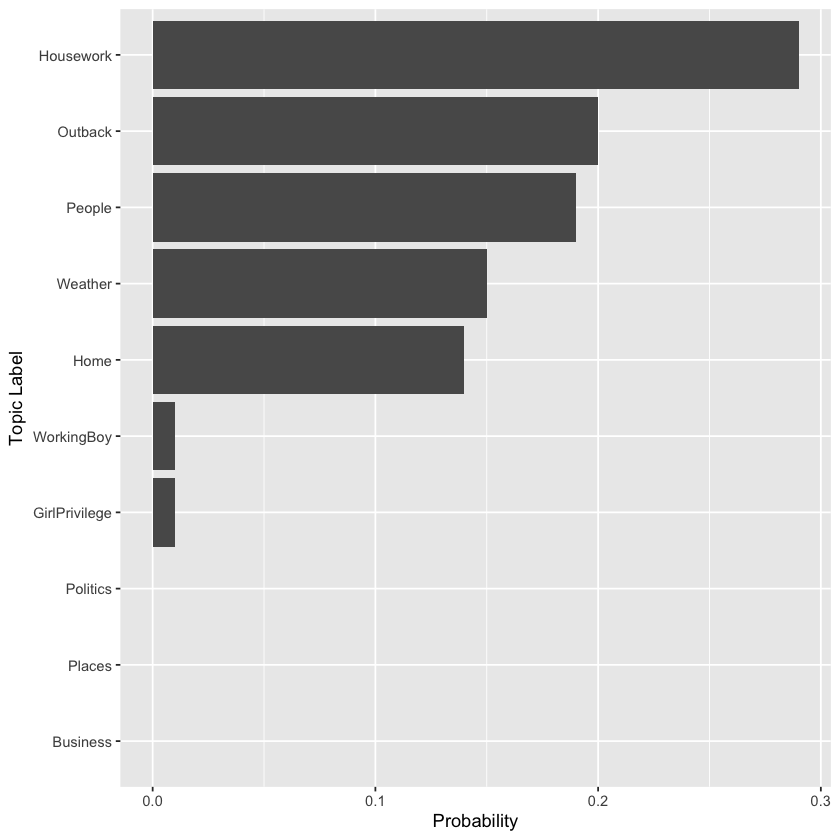

In [250]:
#Get expected values of the posterior predictive distribution
#str(fitted(f4me)) # see what is there
expectedValues <- fitted(f4mupp)[1, , ] %>%  round(digits = 2)

# Put estimates into a table
estimates <- as.data.frame(expectedValues[1,])
colnames(estimates) <- c("Probability")
rownames(estimates) <- c("Housework", "Places", "Business", "GirlPrivilege", "WorkingBoy", "Weather", "People", "Politics", "Outback", "Home")
table <- estimates %>% 
arrange(desc(Probability))
table

#Check to make sure the probabilties add up to 1
round(sum(table$Probability), digits=0)

# Barplot
p  <- ggplot(table, aes(x = reorder(rownames(table), Probability), y=Probability)) + 
  geom_bar(stat = "identity") +
  coord_flip() + xlab("Topic Label")
p

ggsave("20240829_PhD_DiaChkTop02.png")

In [244]:
df2 %>% 
select(docid, sequence) %>% 
group_by(docid) %>% 
summarize(max = max(sequence))

docid,max
<fct>,<int>
D0002,447
D0003,102
D0007,323
D0009,151


### Social Mentions (External)

<p>Partial Pooling Model</p>

$$mentionsRate_{ik} \sim Normal(\mu_{ik}, \sigma)$$
$$\mu_{ik} = \alpha_k$$
$$\alpha_k \sim Normal(\gamma, \phi)* $$ 
$$\gamma \sim Normal(0.04,0.01)* $$ 
$$\phi \sim Uniform(0,0.01)* $$
$$\sigma \sim Uniform(0,0.02)**$$ 

<ul>
    <li>* Typical writer (fixed)</li>
    <li>** Variability for each writer (random).</li>
</ul>

#### Actual Data

docid,min,mean,max,sd
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
D0002,0.013513514,0.04612152,0.10989011,0.015820286
D0003,0.006493506,0.02961932,0.05944056,0.009951083
D0007,0.003703704,0.03119050,0.07692308,0.012755941
D0009,0.010676157,0.04270003,0.11191336,0.016258728


Picking joint bandwidth of 0.0038



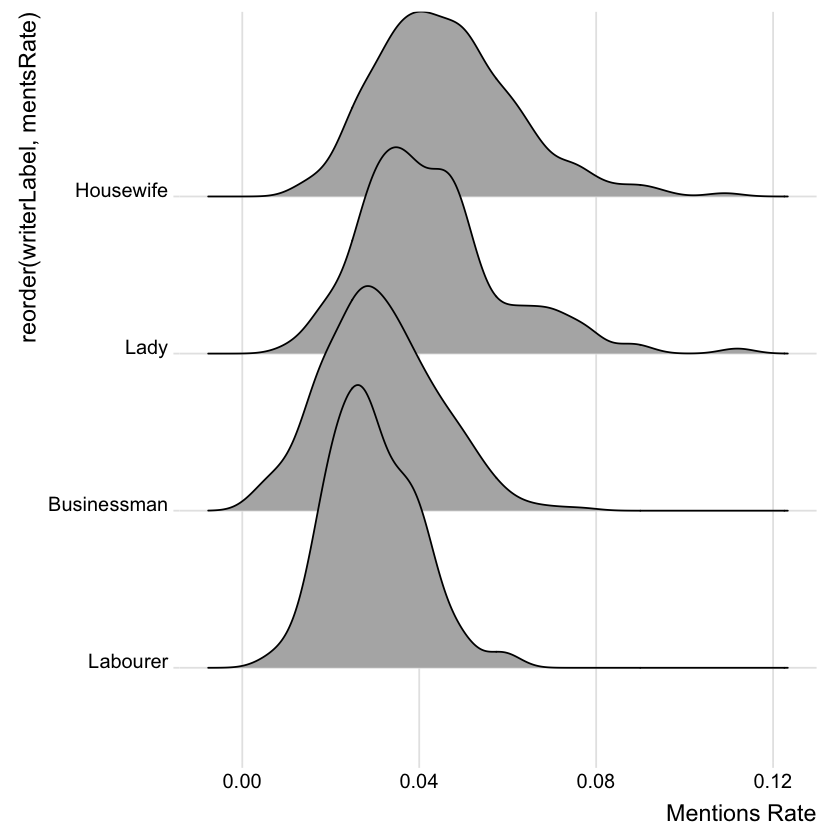

In [260]:
df2 %>% 
select(docid, mentsRate) %>% 
group_by(docid) %>% 
summarize(min = min(mentsRate),
          mean = mean(mentsRate), 
          max = max(mentsRate), 
          sd = sd(mentsRate))

actualData <- df2 %>% 
select(docid, mentsRate) 

actualData$writerLabel[actualData$docid=="D0002"] <- "Housewife"
actualData$writerLabel[actualData$docid=="D0003"] <- "Labourer"
actualData$writerLabel[actualData$docid=="D0007"] <- "Businessman"
actualData$writerLabel[actualData$docid=="D0009"] <- "Lady"

ggplot(actualData, aes(x = mentsRate, y = reorder(writerLabel, mentsRate))) +
  geom_density_ridges() +
  theme_ridges() + 
  theme(legend.position = "none") + 
xlab("Mentions Rate") 

In [20]:
f7mupp <- readRDS("20240829_PhD_ChkSocM_mupp.rds")
print(f7mupp)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: mentsRate ~ 1 + (1 | docauthorid) 
   Data: df2 (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 4) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.01      0.00     0.00     0.01 1.01     1294     1463

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.04      0.00     0.03     0.05 1.00      954     1149

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.01      0.00     0.01     0.02 1.00     1844     1758

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at converg

In [21]:
#f7mupp <- brm(data=df2,
#    family = 'gaussian',
#    formula= mentsRate ~ 1 + (1 | docauthorid),
#    prior=c(
#        set_prior("normal(.04,.01)",class="Intercept"),
#        set_prior("uniform(0,.01)",class="sd", ub=.01), #phi
#        set_prior("uniform(0,.02)",class="sigma", ub=.02)
#    ),
#    iter=2000, warmup = 1000, chains=4, cores=4, seed = 4,
#    file = "20240829_PhD_ChkSocM_mupp.rds",
#    control=list(adapt_delta=.99) 
#)
#print(f7mupp)

Picking joint bandwidth of 0.00248



    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.02393  0.02633  0.03739  0.03729  0.04824  0.09729 

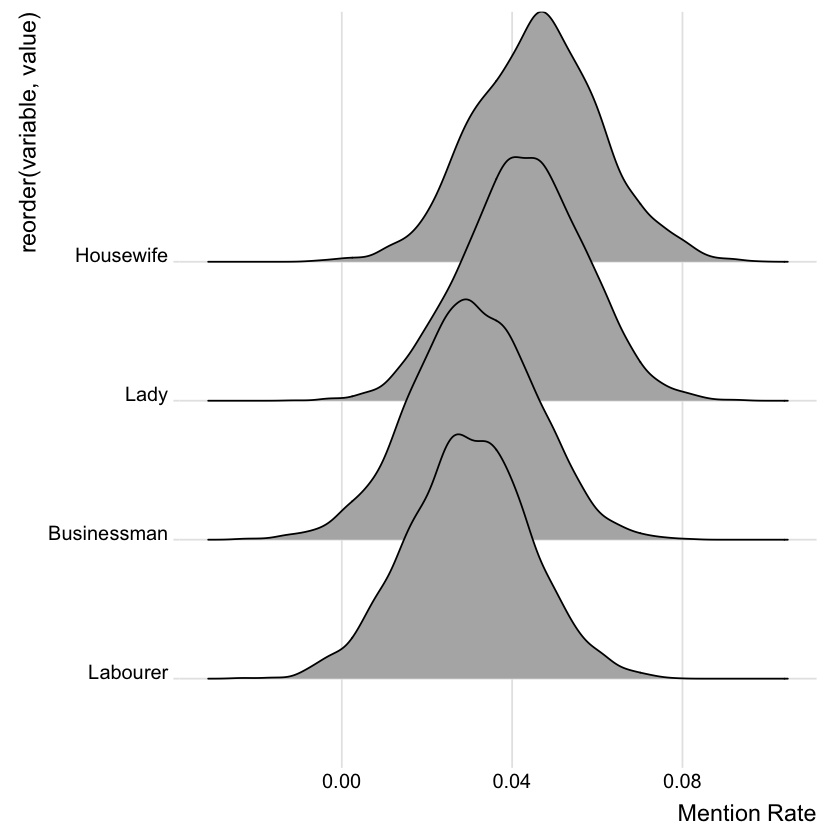

In [280]:
nd <- distinct(df2, docauthorid)

f <-
  predict(f7mupp,
         newdata = nd,
         summary = F)  %>% 
data.frame()

colnames(f) <- c("Housewife", "Labourer", "Businessman", "Lady")

f <- f %>%                                   
  gather(variable, value) 

ggplot(f, aes(x = value, y = reorder(variable, value))) +
  geom_density_ridges() +
theme_ridges() + 
  theme(legend.position = "none") + 
xlab("Mention Rate") 

summary(f$value)

In [281]:
# Random Effects
post_mdn <- 
  coef(f7mupp, robust = T)$docauthorid[, , ] %>% 
  data.frame()

head(post_mdn)

,Estimate,Est.Error,Q2.5,Q97.5
,<dbl>,<dbl>,<dbl>,<dbl>
D0002,0.04603871,0.0006921622,0.04475141,0.04734379
D0003,0.02996681,0.0014040330,0.02725995,0.03275694
D0007,0.03128944,0.0007889862,0.02967615,0.03284910
D0009,0.04256451,0.0011265597,0.04029049,0.04483840


Picking joint bandwidth of 0.000611



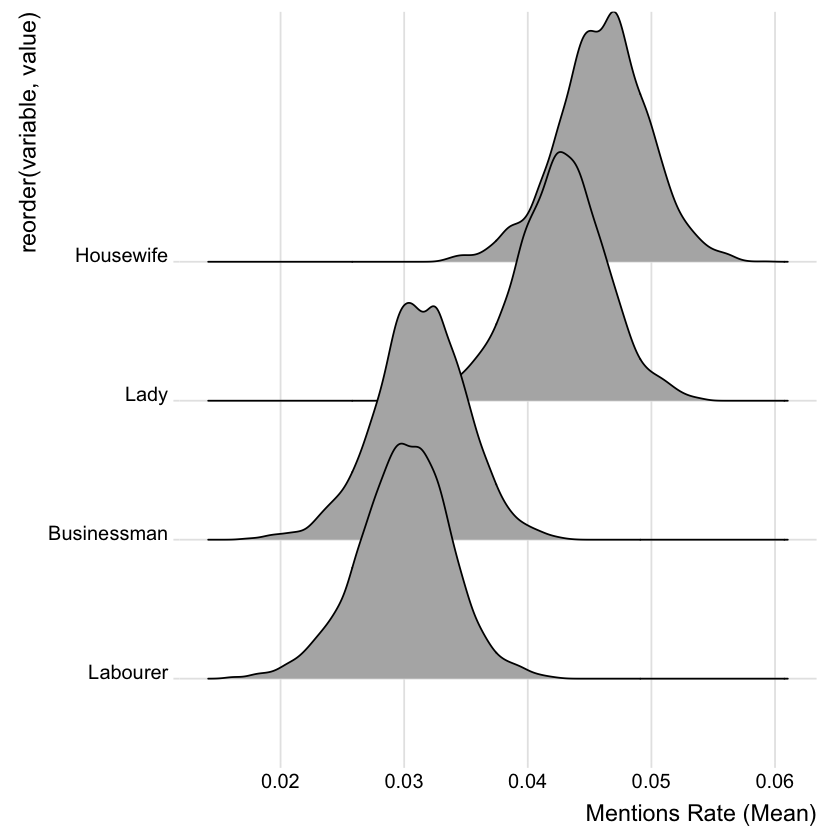

In [276]:
#Visualized Random Effects (Means)

nd <- distinct(df2, docauthorid)

f <- data.frame(ranef(f7mupp,
         newdata = nd,
         re_formula = NA,
         probs = c(.1, .90), 
         summary = F))

colnames(f) <- c("Housewife", "Labourer", "Businessman", "Lady")

fe <- fixef(f7mupp, probs = .90)

f$Housewife <- fe[1,1] + f$Housewife
f$Labourer <- fe[1,1] + f$Labourer
f$Businessman <- fe[1,1] + f$Businessman
f$Lady <- fe[1,1] + f$Lady

f <- f %>%                                   
  gather(variable, value) 

ggplot(f, aes(x = value, y = reorder(variable, value))) +
  geom_density_ridges() +
  theme_ridges() + 
  theme(legend.position = "none") + 
xlab("Mentions Rate (Mean)")

#ggsave("20240822_PhD_DiaSenWri.png")

### Self References (All)

<p>Partial Pooling Model</p>

$$fppAllRate_{ik} \sim Normal(\mu_{ik}, \sigma)$$
$$\mu_{ik} = \alpha_k$$
$$\alpha_k \sim Normal(\gamma, \phi)* $$ 
$$\gamma \sim Normal(0.03,0.01)* $$ 
$$\phi \sim Uniform(0,0.01)* $$
$$\sigma \sim Uniform(0,0.02)**$$ 

<ul>
    <li>* Typical writer (fixed)</li>
    <li>** Variability for each writer (random).</li>
</ul>

#### Actual Data

docid,min,mean,max,sd
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
D0002,0.000000000,0.02508714,0.06007067,0.01067975
D0003,0.000000000,0.05628796,0.09342561,0.01688380
D0007,0.000000000,0.01880837,0.07835821,0.01289728
D0009,0.007092199,0.03230725,0.08041958,0.01440364


Picking joint bandwidth of 0.00387



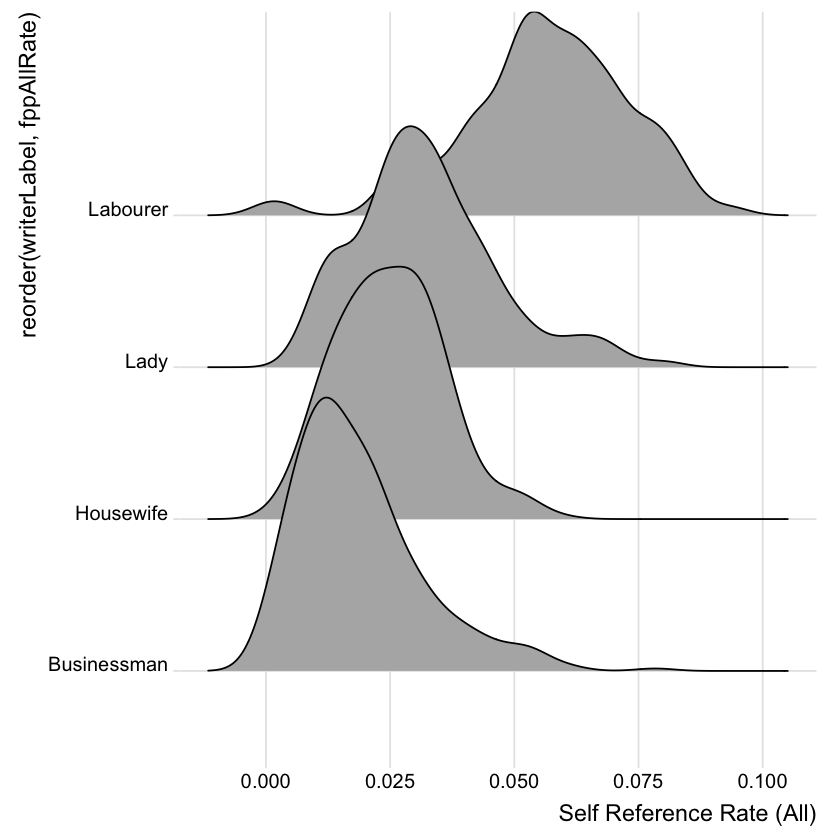

In [283]:
df2 %>% 
select(docid, fppAllRate) %>% 
group_by(docid) %>% 
summarize(min = min(fppAllRate),
          mean = mean(fppAllRate), 
          max = max(fppAllRate), 
          sd = sd(fppAllRate))

actualData <- df2 %>% 
select(docid, fppAllRate) 

actualData$writerLabel[actualData$docid=="D0002"] <- "Housewife"
actualData$writerLabel[actualData$docid=="D0003"] <- "Labourer"
actualData$writerLabel[actualData$docid=="D0007"] <- "Businessman"
actualData$writerLabel[actualData$docid=="D0009"] <- "Lady"

ggplot(actualData, aes(x = fppAllRate, y = reorder(writerLabel, fppAllRate))) +
  geom_density_ridges() +
  theme_ridges() + 
  theme(legend.position = "none") + 
xlab("Self Reference Rate (All)") 

In [22]:
f8mupp <- readRDS("20240829_PhD_ChkSocFppAll_mupp.rds")
print(f8mupp)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: fppAllRate ~ 1 + (1 | docauthorid) 
   Data: df2 (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 4) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.01      0.00     0.01     0.01 1.01     1373     1084

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.03      0.00     0.02     0.04 1.00      924     1303

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.01      0.00     0.01     0.01 1.00     1882     1710

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at conver

In [23]:
#f8mupp <- brm(data=df2,
#    family = 'gaussian',
#    formula= fppAllRate ~ 1 + (1 | docauthorid),
#    prior=c(
#        set_prior("normal(.03,.01)",class="Intercept"),
#        set_prior("uniform(0,.01)",class="sd", ub=.01),
#        set_prior("uniform(0,.02)",class="sigma", ub=.02)
#    ),
#    iter=2000, warmup = 1000, chains=4, cores=4, seed = 4,
#    file = "20240829_PhD_ChkSocFppAll_mupp.rds",
#    control=list(adapt_delta=.99) 
#)
#print(f8mupp)

Picking joint bandwidth of 0.00216



    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.03834  0.01956  0.03121  0.03323  0.04592  0.11303 

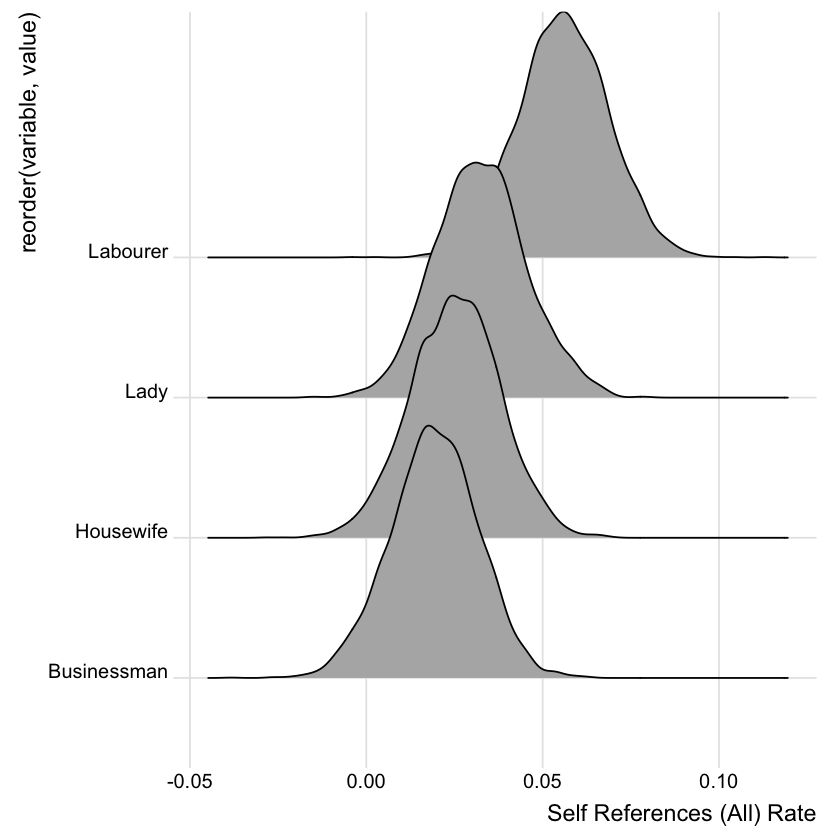

In [300]:
nd <- distinct(df2, docauthorid)

f <-
  predict(f8mupp,
         newdata = nd,
         summary = F)  %>% 
data.frame()

colnames(f) <- c("Housewife", "Labourer", "Businessman", "Lady")

f <- f %>%                                   
  gather(variable, value) 

ggplot(f, aes(x = value, y = reorder(variable, value))) +
  geom_density_ridges() +
theme_ridges() + 
  theme(legend.position = "none") + 
xlab("Self References (All) Rate") 

summary(f$value)

In [301]:
# Random Effects
post_mdn <- 
  coef(f8mupp, robust = T)$docauthorid[, , ] %>% 
  data.frame()

head(post_mdn)

,Estimate,Est.Error,Q2.5,Q97.5
,<dbl>,<dbl>,<dbl>,<dbl>
D0002,0.02511291,0.0005930387,0.02394219,0.02628302
D0003,0.05586225,0.0012597110,0.05331425,0.05826280
D0007,0.01888391,0.0007049949,0.01752970,0.02025100
D0009,0.03232318,0.0010270113,0.03023696,0.03435724


Picking joint bandwidth of 0.000681



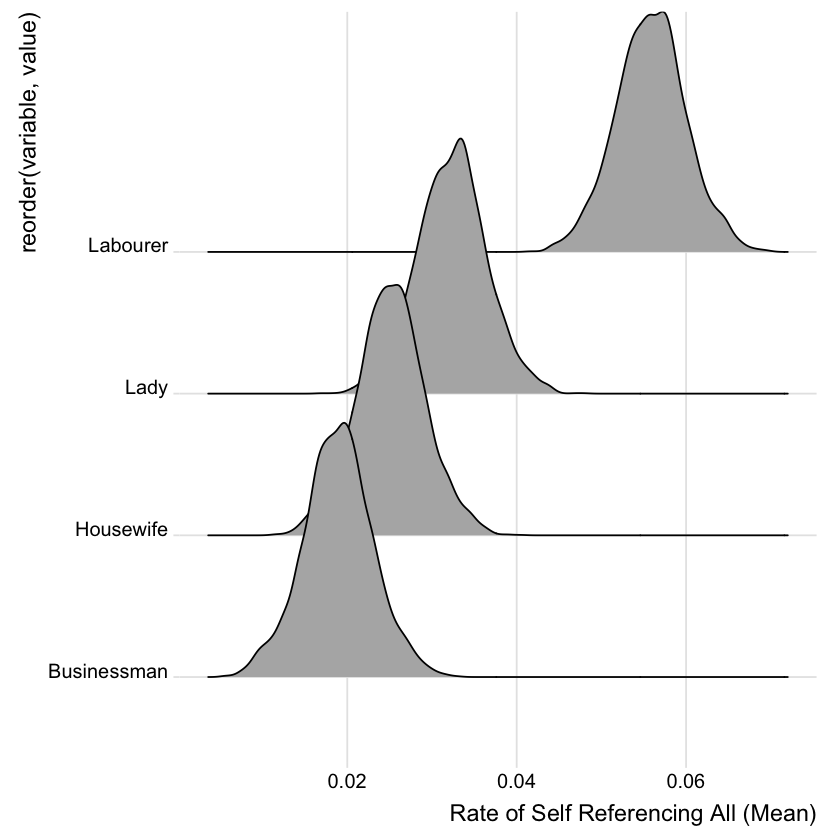

In [302]:
#Visualized Random Effects (Means)

nd <- distinct(df2, docauthorid)

f <- data.frame(ranef(f8mupp,
         newdata = nd,
         re_formula = NA,
         probs = c(.1, .90), 
         summary = F))

colnames(f) <- c("Housewife", "Labourer", "Businessman", "Lady")

fe <- fixef(f8mupp, probs = .90)

f$Housewife <- fe[1,1] + f$Housewife
f$Labourer <- fe[1,1] + f$Labourer
f$Businessman <- fe[1,1] + f$Businessman
f$Lady <- fe[1,1] + f$Lady

f <- f %>%                                   
  gather(variable, value) 

ggplot(f, aes(x = value, y = reorder(variable, value))) +
  geom_density_ridges() +
  theme_ridges() + 
  theme(legend.position = "none") + 
xlab("Rate of Self Referencing All (Mean)")

#ggsave("20240822_PhD_DiaSenWri.png")

### Self References (Subjective)

<p>Partial Pooling Model</p>

$$fppSubRate_{ik} \sim Normal(\mu_{ik}, \sigma)$$
$$\mu_{ik} = \alpha_k$$
$$\alpha_k \sim Normal(\gamma, \phi)* $$ 
$$\gamma \sim Normal(0.02,0.01)* $$ 
$$\phi \sim Uniform(0,0.01)* $$
$$\sigma \sim Uniform(0,0.02)**$$ 

<ul>
    <li>* Typical writer (fixed)</li>
    <li>** Variability for each writer (random).</li>
</ul>

docid,min,mean,max,sd
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
D0002,0.000000000,0.01845463,0.05154639,0.008536596
D0003,0.000000000,0.05094633,0.07958478,0.015660164
D0007,0.000000000,0.01441080,0.05514706,0.010625662
D0009,0.007092199,0.02845712,0.06405694,0.012211898


Picking joint bandwidth of 0.00334



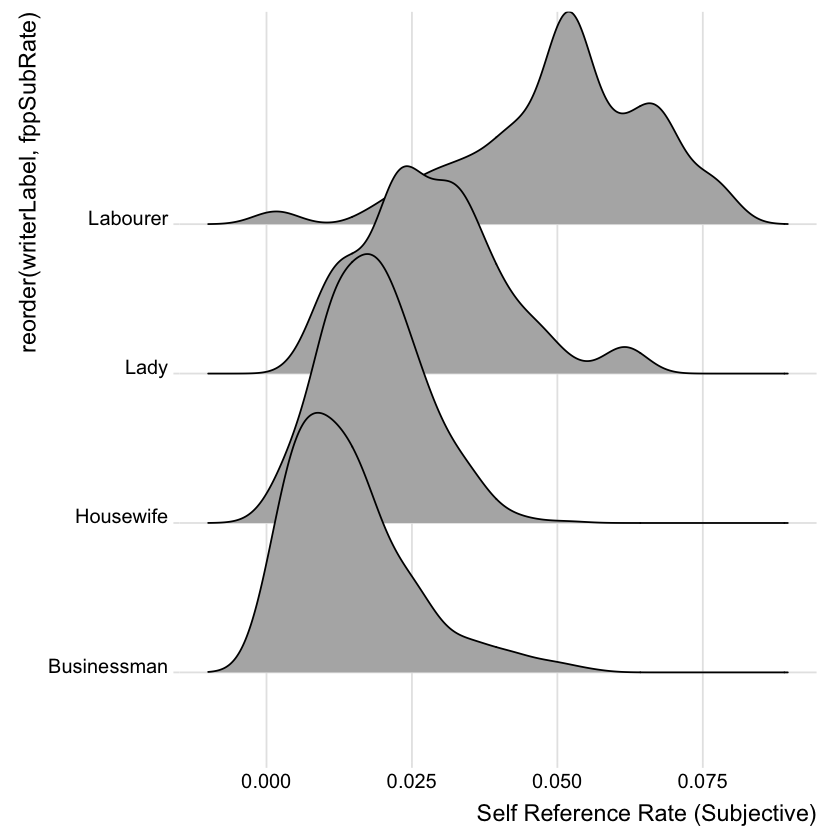

In [297]:
df2 %>% 
select(docid, fppSubRate) %>% 
group_by(docid) %>% 
summarize(min = min(fppSubRate),
          mean = mean(fppSubRate), 
          max = max(fppSubRate), 
          sd = sd(fppSubRate))

actualData <- df2 %>% 
select(docid, fppSubRate) 

actualData$writerLabel[actualData$docid=="D0002"] <- "Housewife"
actualData$writerLabel[actualData$docid=="D0003"] <- "Labourer"
actualData$writerLabel[actualData$docid=="D0007"] <- "Businessman"
actualData$writerLabel[actualData$docid=="D0009"] <- "Lady"

ggplot(actualData, aes(x = fppSubRate, y = reorder(writerLabel, fppSubRate))) +
  geom_density_ridges() +
  theme_ridges() + 
  theme(legend.position = "none") + 
xlab("Self Reference Rate (Subjective)") 

In [24]:
f9mupp <- readRDS("20240829_PhD_ChkSocFppSub_mupp.rds")
print(f9mupp)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: fppSubRate ~ 1 + (1 | docauthorid) 
   Data: df2 (Number of observations: 1023) 
  Draws: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup draws = 4000

Multilevel Hyperparameters:
~docauthorid (Number of levels: 4) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.01      0.00     0.01     0.01 1.01     1445     1357

Regression Coefficients:
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept     0.03      0.00     0.02     0.04 1.01      870     1134

Further Distributional Parameters:
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     0.01      0.00     0.01     0.01 1.00     1697     1702

Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at conver

In [25]:
#f9mupp <- brm(data=df2,
#    family = 'gaussian',
#    formula= fppSubRate ~ 1 + (1 | docauthorid),
#    prior=c(
#        set_prior("normal(.02,.01)",class="Intercept"),
#        set_prior("uniform(0,.01)",class="sd", ub=.01),
#        set_prior("uniform(0,.02)",class="sigma", ub=.02)
#    ),
#    iter=2000, warmup = 1000, chains=4, cores=4, seed = 4,
#    file = "20240829_PhD_ChkSocFppSub_mupp.rds",
#    control=list(adapt_delta=.99) 
#)
#print(f9mupp)

Picking joint bandwidth of 0.00183



    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.02701  0.01506  0.02554  0.02805  0.04027  0.09201 

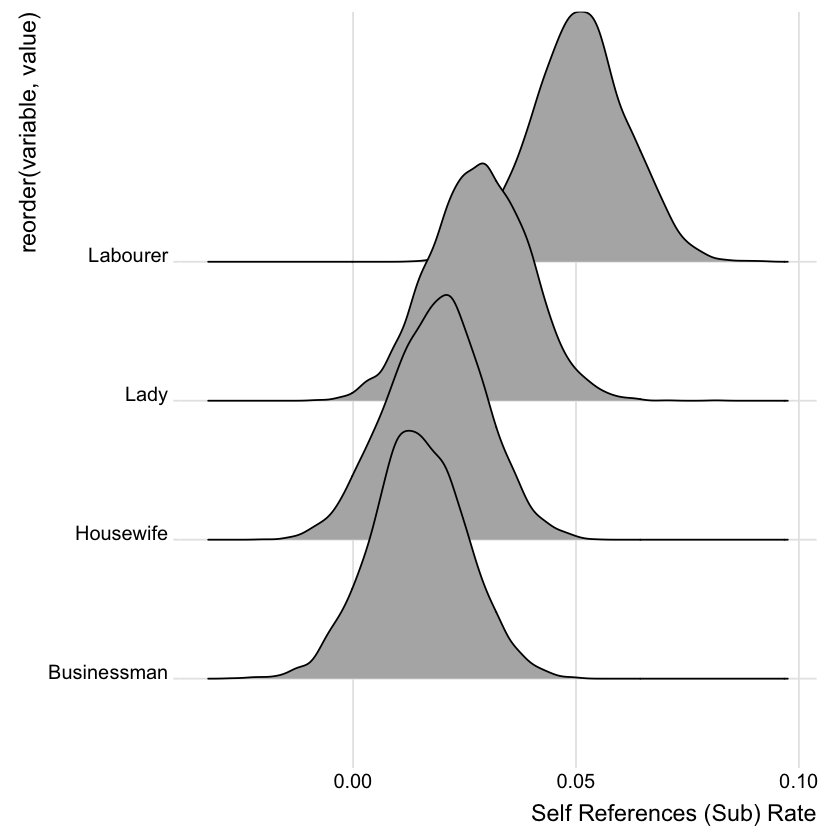

In [303]:
nd <- distinct(df2, docauthorid)

f <-
  predict(f9mupp,
         newdata = nd,
         summary = F)  %>% 
data.frame()

colnames(f) <- c("Housewife", "Labourer", "Businessman", "Lady")

f <- f %>%                                   
  gather(variable, value) 

ggplot(f, aes(x = value, y = reorder(variable, value))) +
  geom_density_ridges() +
theme_ridges() + 
  theme(legend.position = "none") + 
xlab("Self References (Sub) Rate") 

summary(f$value)

In [304]:
# Random Effects
post_mdn <- 
  coef(f9mupp, robust = T)$docauthorid[, , ] %>% 
  data.frame()

head(post_mdn)

,Estimate,Est.Error,Q2.5,Q97.5
,<dbl>,<dbl>,<dbl>,<dbl>
D0002,0.01848618,0.0004901362,0.01747556,0.01948775
D0003,0.05058301,0.0010287749,0.04854798,0.05273342
D0007,0.01447039,0.0005891011,0.01327402,0.01564741
D0009,0.02843601,0.0008996778,0.02669710,0.03022638


Picking joint bandwidth of 0.000727



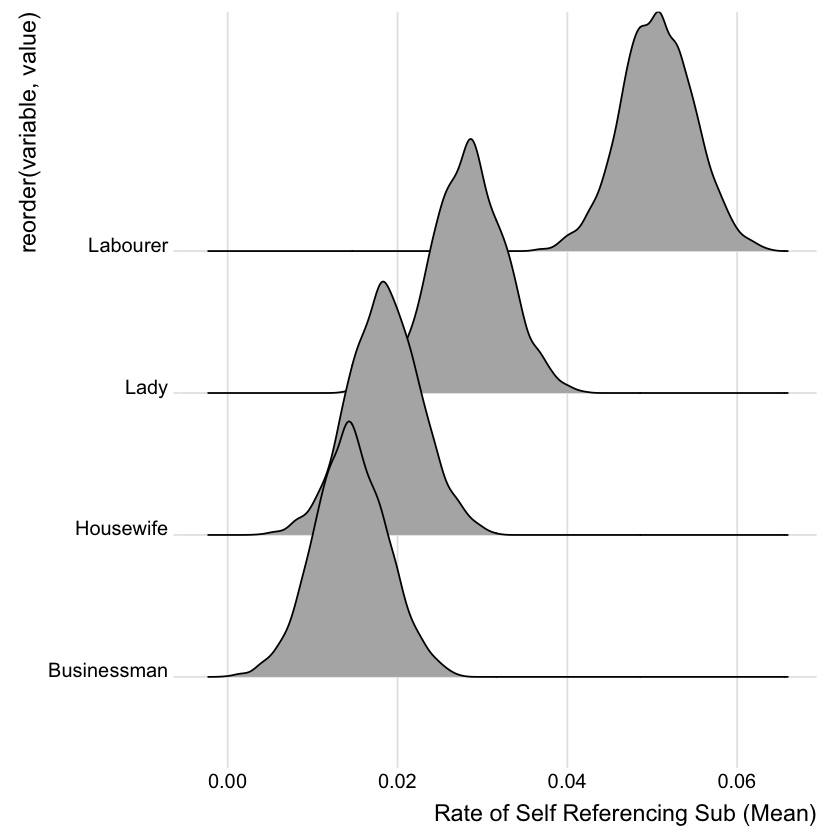

In [305]:
#Visualized Random Effects (Means)

nd <- distinct(df2, docauthorid)

f <- data.frame(ranef(f9mupp,
         newdata = nd,
         re_formula = NA,
         probs = c(.1, .90), 
         summary = F))

colnames(f) <- c("Housewife", "Labourer", "Businessman", "Lady")

fe <- fixef(f9mupp, probs = .90)

f$Housewife <- fe[1,1] + f$Housewife
f$Labourer <- fe[1,1] + f$Labourer
f$Businessman <- fe[1,1] + f$Businessman
f$Lady <- fe[1,1] + f$Lady

f <- f %>%                                   
  gather(variable, value) 

ggplot(f, aes(x = value, y = reorder(variable, value))) +
  geom_density_ridges() +
  theme_ridges() + 
  theme(legend.position = "none") + 
xlab("Rate of Self Referencing Sub (Mean)")

#ggsave("20240822_PhD_DiaSenWri.png")